In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

parent_dir = str(Path().resolve().parents[0])
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
np.random.seed(5)

num_a = 100
num_b = 75
num_blocked_pairs = 2 * (num_a + num_b)

num_iters = int(1e3)

# locs
a = np.arange(num_a)# * (num_b / num_a)
b = np.arange(num_b)

# weights 
mu = np.random.normal(loc=5.0, scale=1.0, size=a.shape[0])
mu_0 = mu.copy()

nu = np.random.normal(loc=7.0, scale=1.5, size=b.shape[0])
nu_0 = nu.copy()

In [3]:
gamma_0 = 10.0 # regularisation
gamma_c = 15.0 # column constraints
gamma_r = 15.0 # row constraints

# select which constraints to enforce
rows_to_relax = np.random.choice([0,1], size=(num_a,1), p=[0.75,0.25])
cols_to_relax = np.random.choice([0,1], size=(1,num_b), p=[0.5,0.5])

# plan constraints
l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)

# Soft Bregman Solver

(100,) (100,) (100, 1)
(75,) (75,) (1, 75)


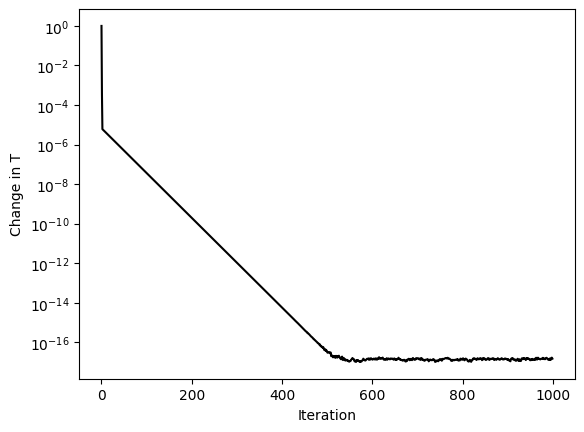

In [4]:
from src.utils.solvers import SoftBregman

blocked_idxs = zip(l_idxs_x, l_idxs_y)

print(a.shape, mu.shape, rows_to_relax.shape)
print(b.shape, nu.shape, cols_to_relax.shape)

solver = SoftBregman(gamma_0, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs=blocked_idxs)
T = solver.solve(a, b, mu, nu, plot=True)

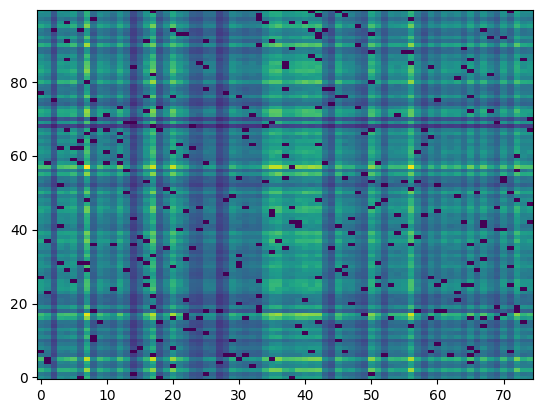

In [5]:
plt.pcolormesh(b, a, T)

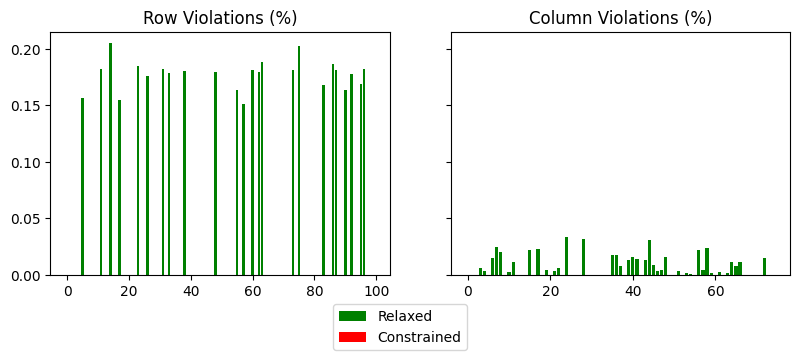

In [6]:
from matplotlib.patches import Patch

fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(9,4), sharey='row')

def binary_to_colour(arr):
    colours = np.array(arr, dtype=str)
    colours[arr == 1] = 'green'
    colours[arr == 0] = 'red'
    return colours

ax_r.bar(x=np.arange(num_a), height=np.abs(mu_0 - np.sum(T, axis=1)) / mu_0, color=binary_to_colour(rows_to_relax.reshape(-1,)))
ax_r.set_title('Row Violations (%)')

ax_c.bar(x=np.arange(num_b), height=np.abs(nu_0 - np.sum(T, axis=0)) / nu_0, color=binary_to_colour(cols_to_relax.reshape(-1,)))
ax_c.set_title('Column Violations (%)')

fig.tight_layout(pad=4)
fig.legend(labels=['Relaxed', 'Constrained'], handles=[Patch(facecolor='green'), Patch(facecolor='red')], loc='outside lower center')

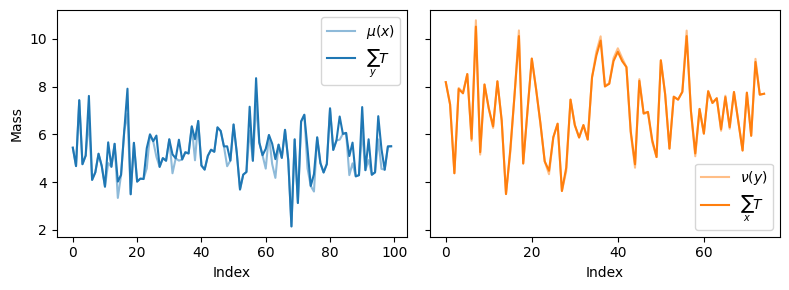

In [7]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

# Dykstra Bounded Solver

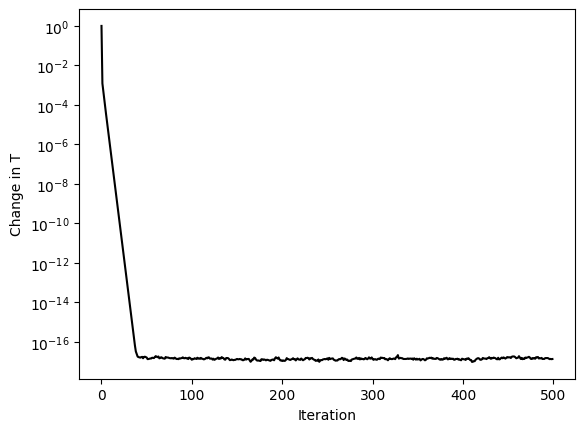

In [8]:
from src.utils.solvers import BoundedDykstra

blocked_idxs = zip(l_idxs_x, l_idxs_y)

m_ub, m_lb = mu.copy(), mu.copy()
m_ub[np.where(rows_to_relax == 1)[0]] *= 1.2
m_lb[np.where(rows_to_relax == 1)[0]] *= 0.8

n_ub, n_lb = nu.copy(), nu.copy()
n_ub[np.where(cols_to_relax == 1)[1]] *= 1.2
n_lb[np.where(cols_to_relax == 1)[1]] *= 0.8

solver = BoundedDykstra(gamma_0, m_ub, m_lb, n_ub, n_lb, blocked_idxs=blocked_idxs)
T = solver.solve(a, b, mu, nu, num_iters=int(5e2), plot=True)

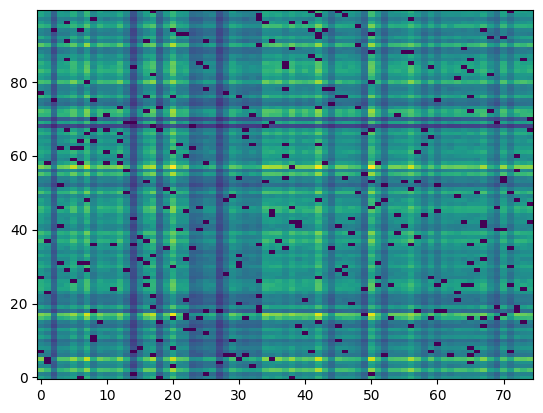

In [9]:
plt.pcolormesh(b, a, T)

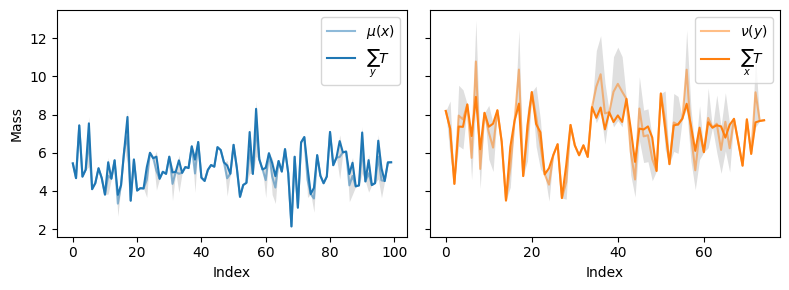

In [10]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].fill_between(a, m_ub, m_lb, color='gray', alpha=0.25, lw=0)
axs[1].fill_between(b, n_ub, n_lb, color='gray', alpha=0.25, lw=0)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

# Two Moons Example

In [11]:
from sklearn.datasets import make_moons

from jax import vmap
from functools import partial

def alpha_scaler(x, T, thresh):
    return (x - thresh) / (np.max(T) - thresh)

@partial(vmap, in_axes=(0, None, None))
def minmax_scaler(x, max_val, min_val):
    return ((x - min_val) / (max_val - min_val)).round(5)

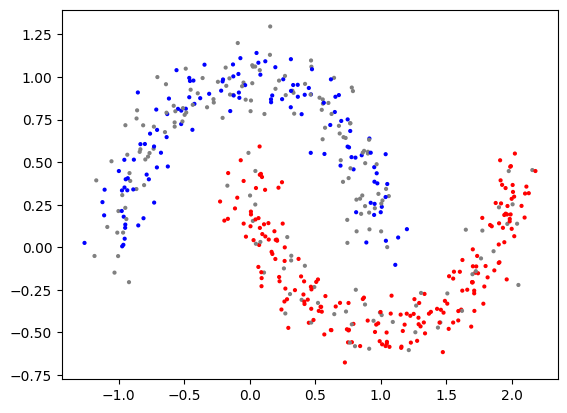

In [12]:
n = 500
gamma = 10.0
gamma_r = 100.0
gamma_c = 100.0
colors = np.array(['blue', 'red', 'grey'])

# make dataset
X, y_true = make_moons(n, noise=0.1, random_state=1)
X_0 = X[y_true == 0]
X_1 = X[y_true == 1]

# perturb labels to have some unknown data
y = y_true.copy()
unlabelled_mask_0 = np.where(np.logical_and(y_true == 0, np.random.random(500) >= 0.5))[0]
y[unlabelled_mask_0] = 2
unlabelled_mask_1 = np.where(np.logical_and(y_true == 1, np.random.random(500) >= 0.75))[0]
y[unlabelled_mask_1] = 2

y_0 = y[y_true == 0]
y_1 = y[y_true == 1]

plt.scatter(*X.T, color=colors[y], s=4)

(250, 2) (250,) (250, 1)
(250, 2) (250,) (1, 250)


/Users/al4518/Desktop/PhD/constrained-ot/src/utils/solvers.py:87: RuntimeWarning: overflow encountered in divide
  D2 = np.divide(nu[None,:], np.sum(T, axis=0, keepdims=True), out=np.ones_like(nu[None,:]), where=(np.sum(T, axis=0, keepdims=True) != 0.0))
/Users/al4518/Desktop/PhD/constrained-ot/src/utils/solvers.py:84: RuntimeWarning: invalid value encountered in multiply
  T = D1 * T


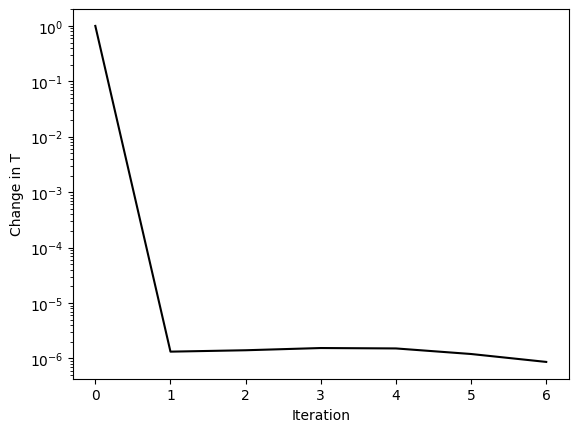

In [ ]:
from src.utils.solvers import SoftBregman

rows_to_relax = (y_0 == 2).reshape(-1, 1)
cols_to_relax = (y_1 == 2).reshape(1, -1)

mu = np.ones(X_0.shape[0]) / n
nu = np.ones(X_1.shape[0]) / n

def C(x, y):
    return (np.abs(x - y) ** 2).sum(axis=-1)

print(X_0.shape, mu.shape, rows_to_relax.shape)
print(X_1.shape, nu.shape, cols_to_relax.shape)

solver = SoftBregman(gamma, gamma_c, gamma_r, rows_to_relax, cols_to_relax)
T = solver.solve(X_0, X_1, mu, nu, C=C(X_0[:, None], X_1[None, :]), plot=True)

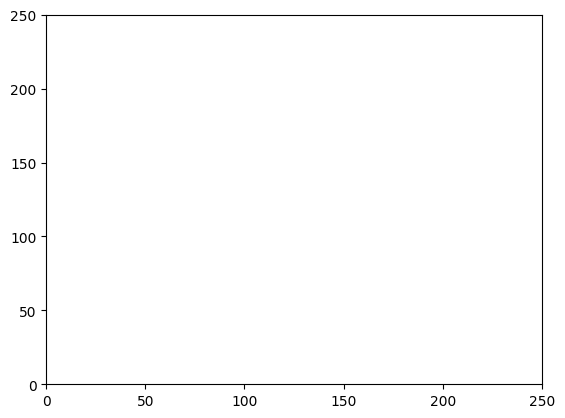

In [14]:
plt.pcolormesh(T)

(0.0015, 0.05500000000000001)

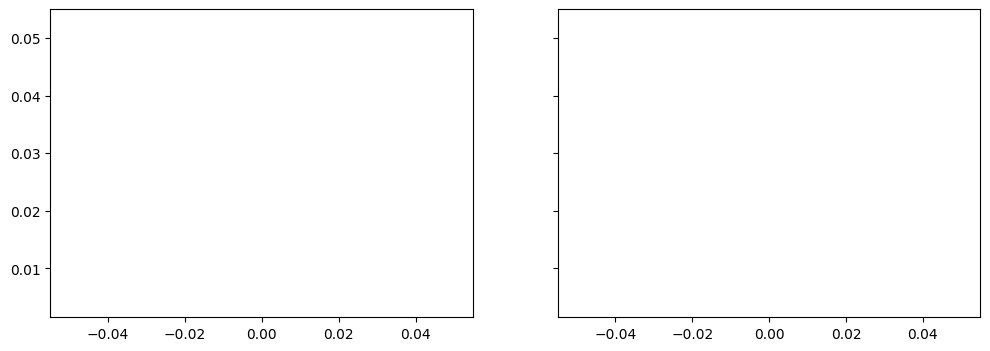

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey='row')

axs[0].bar(x=range(len(X_0)), height=np.sum(T, axis=1), width=1, color=colors[y_0], alpha=0.5)
axs[1].bar(x=range(len(X_1)), height=np.sum(T, axis=0), width=1, color=colors[y_1], alpha=0.5)

axs[0].set_ylim(0.0015, None)

ValueError: alpha must be between 0 and 1, inclusive, but min is nan, max is nan

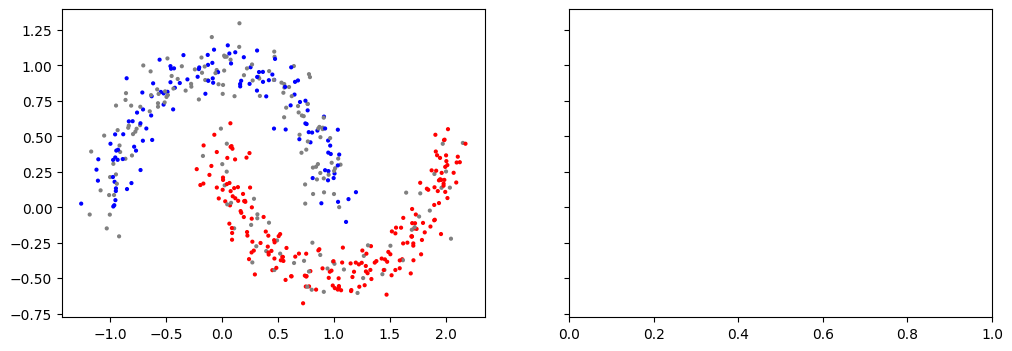

In [16]:
weights_0 = np.sum(T, axis=1) / mu
weights_1 = np.sum(T, axis=0) / nu

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey='row')

axs[0].scatter(*X.T, color=colors[y], s=4)

axs[1].scatter(*X_0.T, color=colors[y_0], s=4, alpha=minmax_scaler(weights_0, np.max(weights_0), np.min(weights_0)*0.8))
axs[1].scatter(*X_1.T, color=colors[y_1], s=4, alpha=minmax_scaler(weights_1, np.max(weights_1), np.min(weights_1)*0.8))

axs[0].set_title('Original Data')
axs[1].set_title('Weights After Transportation')

## Bounded Two Moons

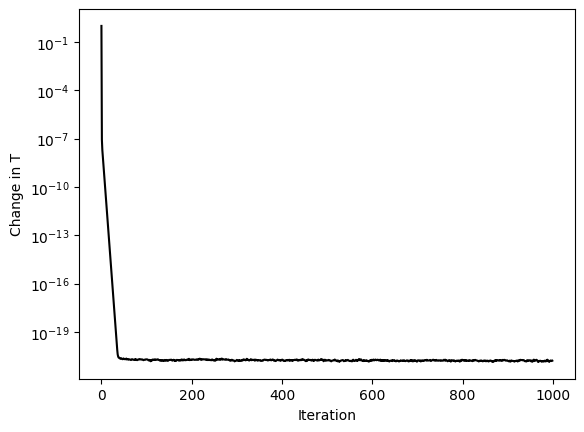

In [ ]:
m_ub, m_lb = mu.copy(), mu.copy()
# m_ub[np.where(rows_to_relax == 1)[0]] *= 1.2
m_lb[np.where(rows_to_relax == 1)[0]] = 1e-12

n_ub, n_lb = nu.copy(), nu.copy()
# n_ub[np.where(cols_to_relax == 1)[1]] *= 1.2
n_lb[np.where(cols_to_relax == 1)[1]] = 1e-12

solver = BoundedDykstra(gamma, m_ub, m_lb, n_ub, n_lb)
T = solver.solve(X_0, X_1, mu, nu, C=C(X_0[:, None], X_1[None, :]), plot=True)

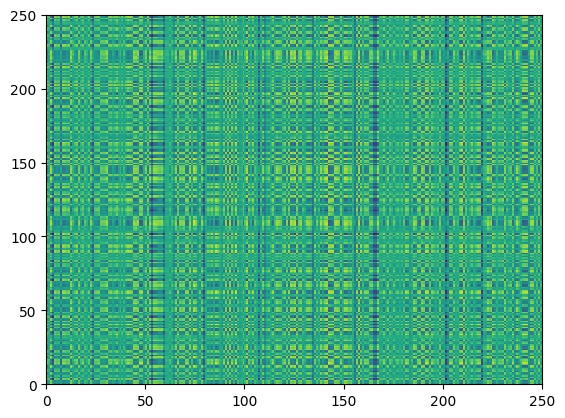

In [ ]:
plt.pcolormesh(T)

Text(0.5, 1.0, 'Weights After Transportation')

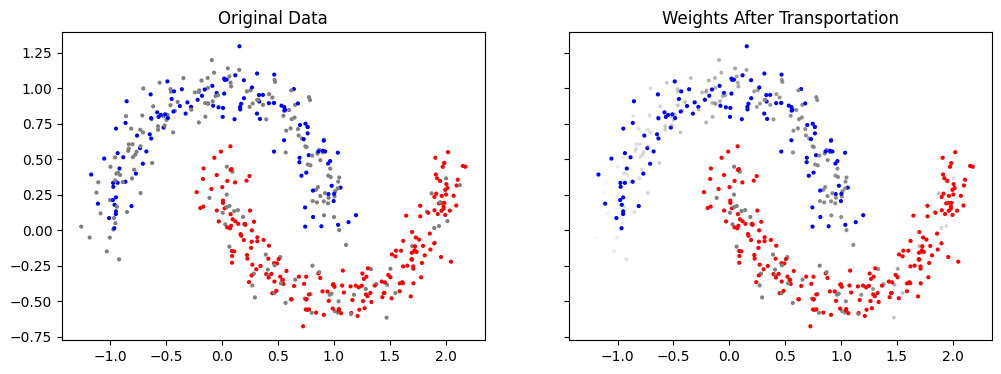

In [ ]:
weights_0 = np.sum(T, axis=1) / mu
weights_1 = np.sum(T, axis=0) / nu

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey='row')

axs[0].scatter(*X.T, color=colors[y], s=4)

axs[1].scatter(*X_0.T, color=colors[y_0], s=4, alpha=minmax_scaler(weights_0, np.max(weights_0), np.min(weights_0)))
axs[1].scatter(*X_1.T, color=colors[y_1], s=4, alpha=minmax_scaler(weights_1, np.max(weights_1), np.min(weights_1)))

axs[0].set_title('Original Data')
axs[1].set_title('Weights After Transportation')